### Transform from depth to isopycnal coordinates 

(x,y,z,t) to (x, y, $\rho$, t) 

$dV = dx dy dz = dx dy h d\rho$, where $h = dz/d\rho$.

In [1]:
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt

import xgcm 
%matplotlib inline

import numpy as np
from xgcm import Grid
from scipy.linalg import pinv, eig
from numpy.linalg import eigh

In [2]:
# load the grid for taking horizontal gradients
ds = xr.open_zarr('/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored_zarr/')
grid = Grid(ds, periodic='X')

In [3]:
grid = xgcm.Grid(ds, periodic='X')

In [4]:
ds['U'] = grid.interp(ds['U'], 'X')
ds['V'] = grid.interp(ds['V'], 'Y', boundary='extend')

In [24]:
Tcenter = np.linspace(0,8, 81)
dT = Tcenter[1] - Tcenter[0]
Touter = np.append(Tcenter - dT/2, Tcenter[-1] + dT/2)

In [25]:
Tcenter

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. ])

In [26]:
Touter

array([-0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,  0.75,
        0.85,  0.95,  1.05,  1.15,  1.25,  1.35,  1.45,  1.55,  1.65,
        1.75,  1.85,  1.95,  2.05,  2.15,  2.25,  2.35,  2.45,  2.55,
        2.65,  2.75,  2.85,  2.95,  3.05,  3.15,  3.25,  3.35,  3.45,
        3.55,  3.65,  3.75,  3.85,  3.95,  4.05,  4.15,  4.25,  4.35,
        4.45,  4.55,  4.65,  4.75,  4.85,  4.95,  5.05,  5.15,  5.25,
        5.35,  5.45,  5.55,  5.65,  5.75,  5.85,  5.95,  6.05,  6.15,
        6.25,  6.35,  6.45,  6.55,  6.65,  6.75,  6.85,  6.95,  7.05,
        7.15,  7.25,  7.35,  7.45,  7.55,  7.65,  7.75,  7.85,  7.95,
        8.05])

In [27]:
# select a part of the data during initial calculations
ds = ds.isel(time=slice(0, 10))
ds = ds.chunk({'Z':-1, 'time':1, 'XC':400, 'YC':400,
                  'XC':400, 'YG':400, 'Zl':-1})

In [28]:
# cast available variables into isopycnal coordinates 
ds_iso = xr.Dataset()

for var_name in ['U','V','T','PTRACER01']:
    print(var_name)
    if var_name != 'T':
        ds_iso[var_name] = grid.transform(ds[var_name], 'Z', Tcenter,
                        target_data=ds['T'], method='linear')

U
V
T
PTRACER01


In [29]:
# this is the variable \zeta 
Z_grid = ds.Z*ds['T']/ds['T'] # convert Z array to a 3D field
ds_iso['zeta'] = grid.transform(Z_grid, 'Z', Tcenter, 
                        target_data=ds['T'], method='linear')

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: divide by zero encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


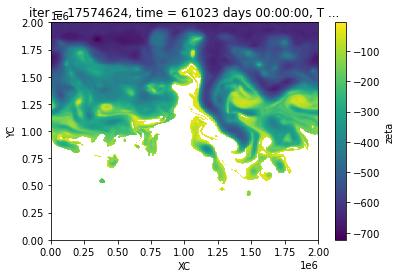

In [13]:
ds_iso['zeta'].isel(time=0).sel(T=4, method='nearest').plot()

In [31]:
ds_iso = ds_iso.assign_coords({'Tc':Touter})
grid_iso = Grid(ds_iso, coords={'T':{'center':'T', 'outer':'Tc'}},
                periodic='X')
# thickness
ds_iso['sigma'] = grid_iso.interp(grid_iso.diff(ds_iso['zeta'], 'T', boundary='extend')/ dT, 
                             'T', boundary='extend')

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: divide by zero encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


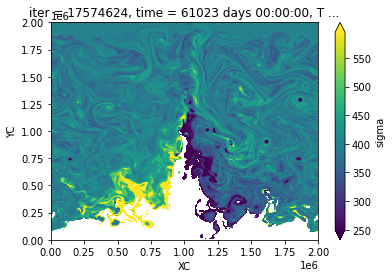

In [36]:
ds_iso['sigma'].isel(time=0).sel(T=2, method='nearest').plot(robust=True)

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: divide by zero encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


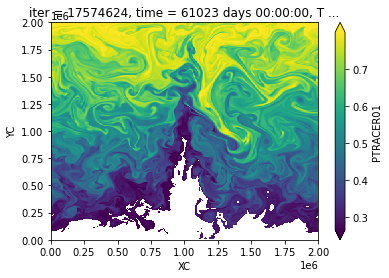

In [37]:
ds_iso['PTRACER01'].isel(time=0).sel(T=2, method='nearest').plot(robust=True)

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: divide by zero encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: divide by zero encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_t

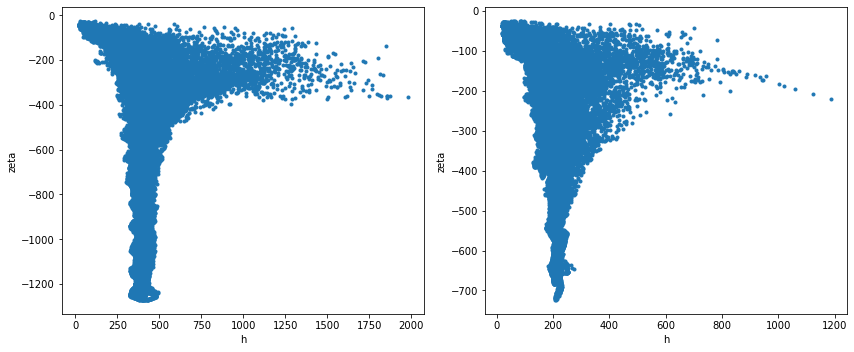

In [42]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(ds_iso['sigma'].isel(time=0).sel(T=2, method='nearest').values.reshape(-1), 
         ds_iso['zeta'].isel(time=0).sel(T=2, method='nearest').values.reshape(-1), '.' );
plt.xlabel('h')
plt.ylabel('zeta')

plt.subplot(122)
plt.plot(ds_iso['sigma'].isel(time=0).sel(T=4, method='nearest').values.reshape(-1), 
         ds_iso['zeta'].isel(time=0).sel(T=4, method='nearest').values.reshape(-1), '.' );
plt.xlabel('h')
plt.ylabel('zeta')

plt.tight_layout()

In [44]:
# cast into TW averages  
ds_hat = xr.Dataset()

sigma_bar = ds_iso['sigma'].mean('time')
zeta_bar  = ds_iso['zeta'].mean('time')

for var_name in ['U','V','PTRACER01']:
    
    if (var_name != 'zeta' and var_name != 'sigma'):
        print(var_name)
        ds_hat[var_name] = (ds_iso[var_name]*ds_iso['sigma']).mean('time')/sigma_bar

U
V
PTRACER01


/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: divide by zero encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: divide by zero encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_t

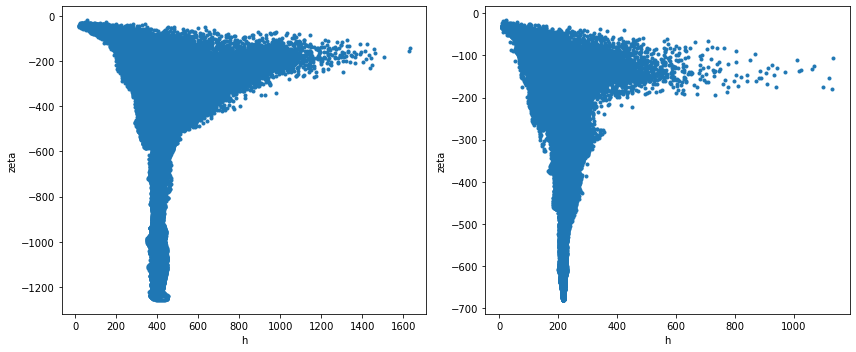

In [46]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(sigma_bar.sel(T=2, method='nearest').values.reshape(-1), 
         zeta_bar.sel(T=2, method='nearest').values.reshape(-1), '.' );
plt.xlabel('h')
plt.ylabel('zeta')

plt.subplot(122)
plt.plot(sigma_bar.sel(T=4, method='nearest').values.reshape(-1), 
         zeta_bar.sel(T=4, method='nearest').values.reshape(-1), '.' );
plt.xlabel('h')
plt.ylabel('zeta')

plt.tight_layout()

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: divide by zero encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


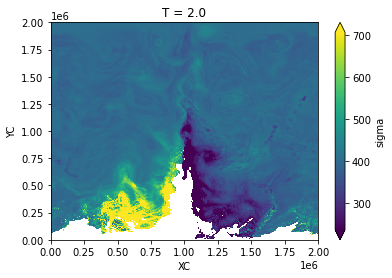

In [47]:
sigma_bar.sel(T=2, method='nearest').plot(robust=True)

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: divide by zero encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


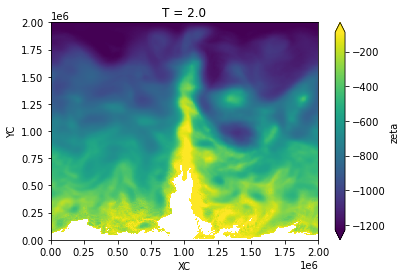

In [48]:
zeta_bar.sel(T=2, method='nearest').plot(robust=True)

### Scraps

In [7]:
Z = ds.Z
theta = ds['T'].sel(XC=0, YC=1000e3, method='nearest').isel(time=0).chunk({'Z':-1})
C = ds['PTRACER01'].sel(XC=0, YC=1000e3, method='nearest').isel(time=0).chunk({'Z':-1})

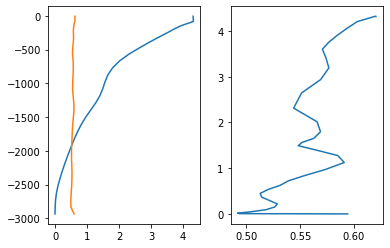

In [4]:
plt.subplot(121)
plt.plot(theta, Z)
plt.plot(C, Z)

plt.subplot(122)
plt.plot(C, theta) # this is a sort of linear interp done by matplotlib

In [5]:
theta_target = np.linspace(0, 5, 50)

In [8]:
C_transformed = grid.transform(C, 'Z', theta_target, target_data=theta)

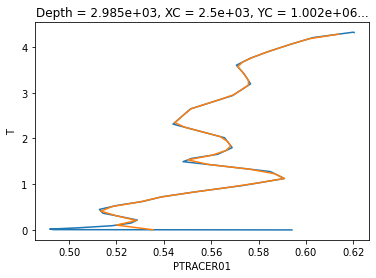

In [12]:
plt.plot(C, theta)
C_transformed.plot(y='T')

#### Conservative mapping

In [77]:
print(theta.min().values)
print(theta.max().values)

-0.0036308116
4.326321


In [76]:
theta_target = np.linspace(-0.5, 4.5, 101)

In [79]:
theta_outer = grid.interp(theta, 'Z', to='outer', boundary='fill').rename('T_outer').chunk({'Zp1':-1})

In [87]:
theta_target.shape

(101,)

In [80]:
print(theta_outer.min().values)
print(theta_outer.max().values)

-0.0018154058
4.3258104


In [90]:
Cdz = (C*ds.drF).chunk({'Z':-1})
Cdz

<xarray.DataArray (Z: 40)>
dask.array<rechunk-merge, shape=(40,), dtype=float32, chunksize=(40,), chunktype=numpy.ndarray>
Coordinates:
    Depth    float32 dask.array<chunksize=(), meta=np.ndarray>
    PHrefC   (Z) float32 dask.array<chunksize=(40,), meta=np.ndarray>
    XC       float32 2.5e+03
    YC       float32 1.002e+06
  * Z        (Z) float32 -5.0 -15.0 -25.0 ... -2.728e+03 -2.83e+03 -2.934e+03
    drF      (Z) float32 dask.array<chunksize=(40,), meta=np.ndarray>
    hFacC    (Z) float32 dask.array<chunksize=(40,), meta=np.ndarray>
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    maskC    (Z) bool dask.array<chunksize=(40,), meta=np.ndarray>
    rA       float32 dask.array<chunksize=(), meta=np.ndarray>
    time     timedelta64[ns] 61023 days

In [91]:
Cdz_transformed_cons = grid.transform( Cdz,
                                   'Z',
                                   theta_target, 
                                   method='conservative',
                                   target_data=theta_outer)

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


In [98]:
Cdz_transformed_cons

<xarray.DataArray (T_outer: 100)>
dask.array<transpose, shape=(100,), dtype=float32, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
    Depth    float32 dask.array<chunksize=(), meta=np.ndarray>
    XC       float32 2.5e+03
    YC       float32 1.002e+06
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    rA       float32 dask.array<chunksize=(), meta=np.ndarray>
    time     timedelta64[ns] 61023 days
  * T_outer  (T_outer) float64 -0.475 -0.425 -0.375 -0.325 ... 4.375 4.425 4.475

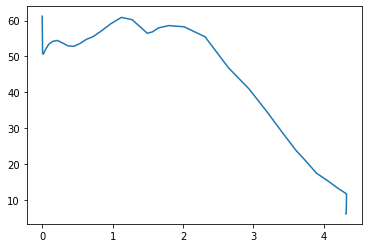

In [99]:
plt.plot(theta , Cdz)

(0.0, 70.0)

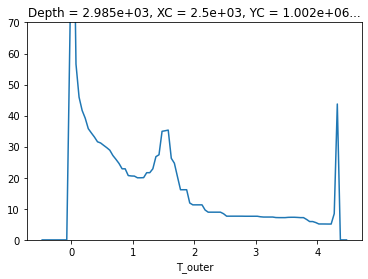

In [100]:
Cdz_transformed_cons.plot()
plt.ylim([0, 70])

In [96]:
Cdz_transformed_cons.sum().values

array(1637.3274, dtype=float32)

In [97]:
Cdz.sum().values

array(1637.3274, dtype=float32)

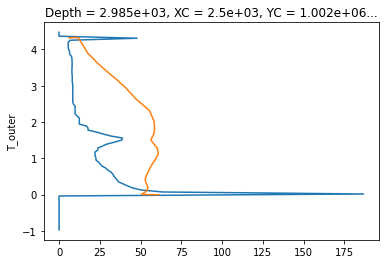

In [64]:
Cdz_transformed_cons.plot(y='T_outer')
plt.plot(Cdz, theta)